In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3a
commitnumber = a22ab94
conc = 0.0008
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 300
vmax = 620
vmin = 540
w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.55, 1.6, 1.85)]
wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

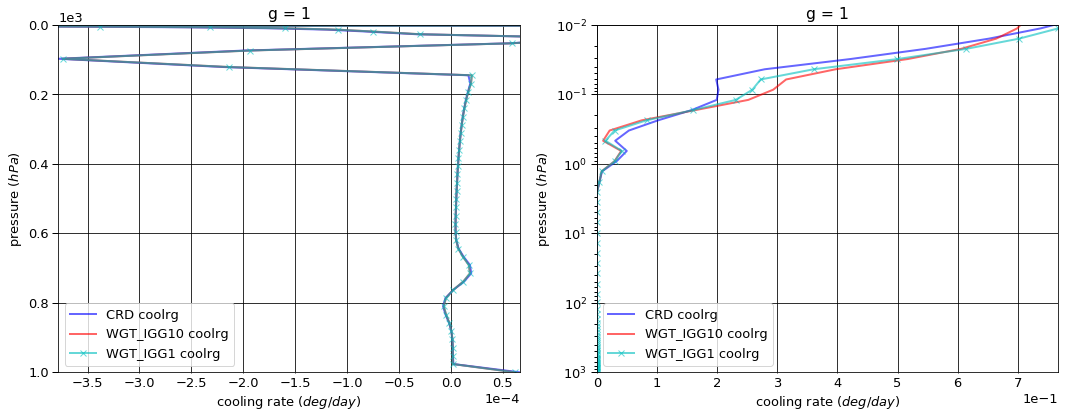

# Figure: cooling rate g-group 2

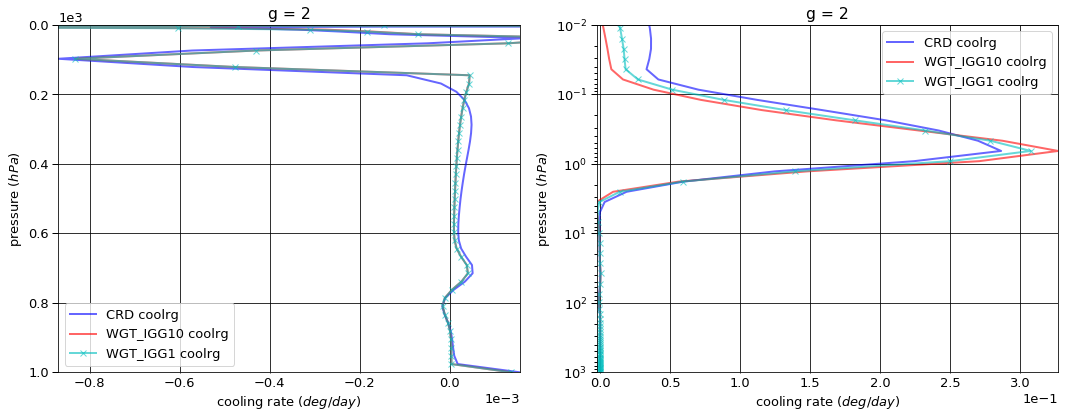

# Figure: cooling rate g-group 3

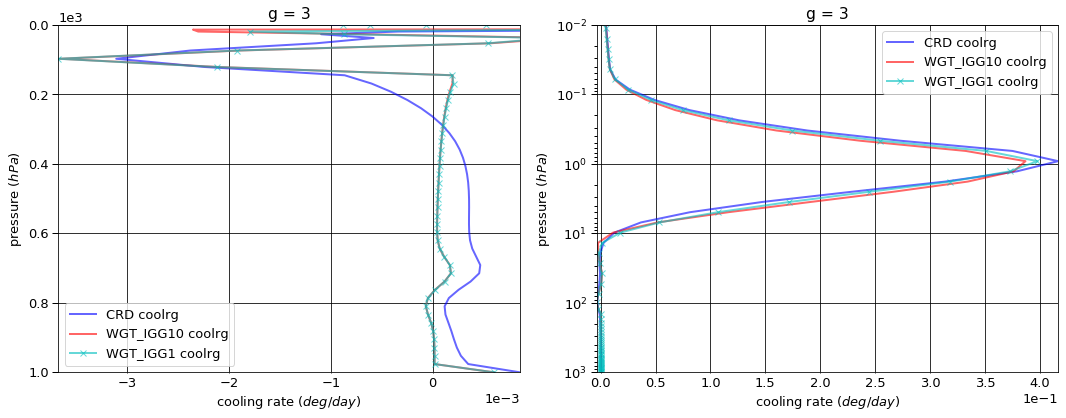

# Figure: cooling rate g-group 4

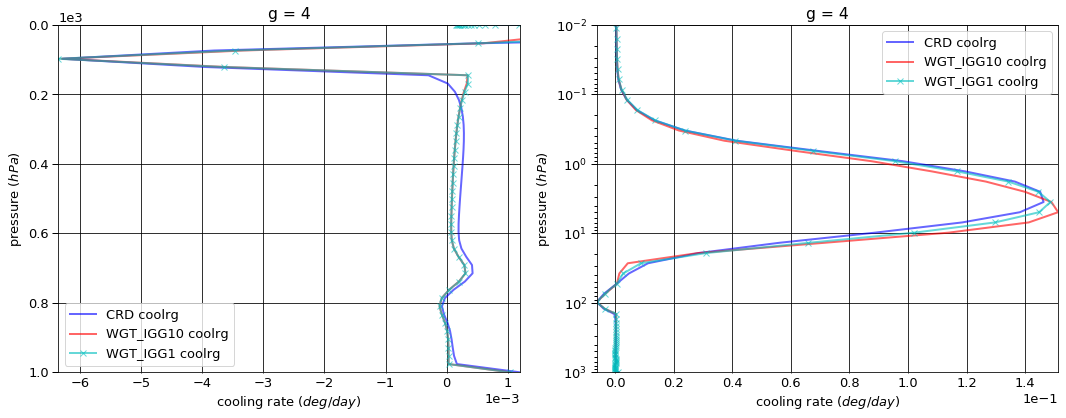

# Figure: cooling rate g-group 5

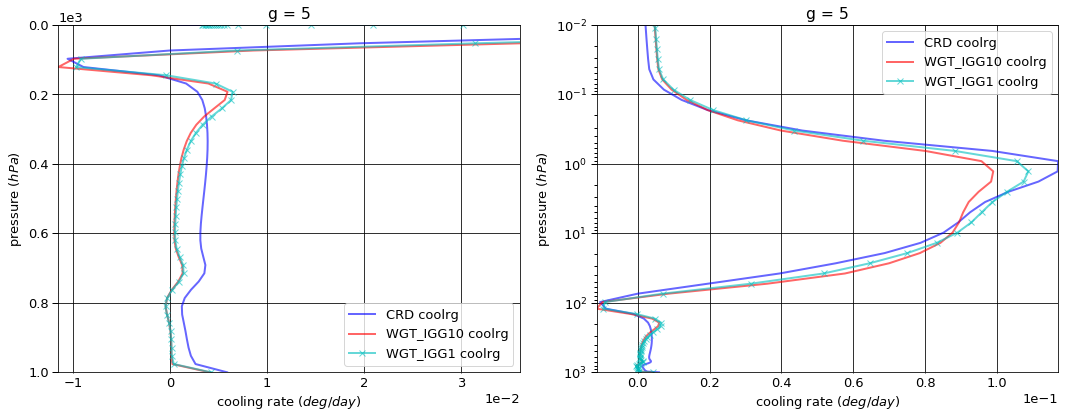

# Figure: cooling rate g-group 6

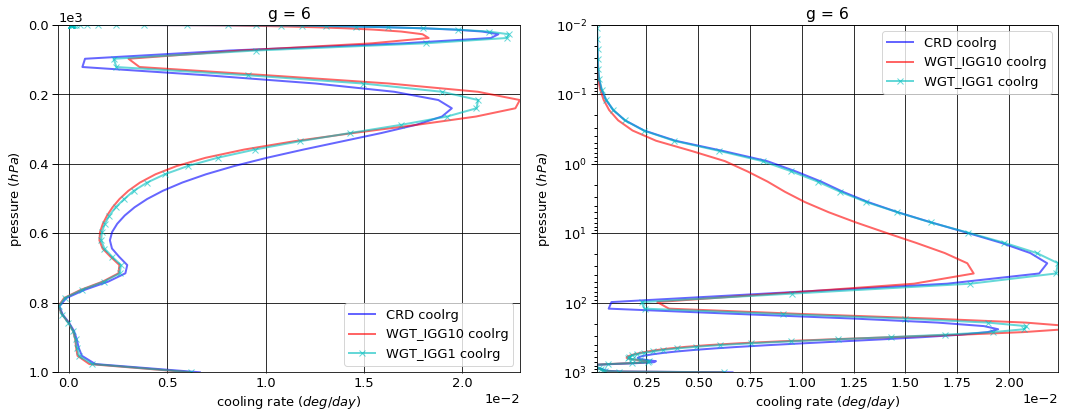

# Figure: cooling rate g-group 7

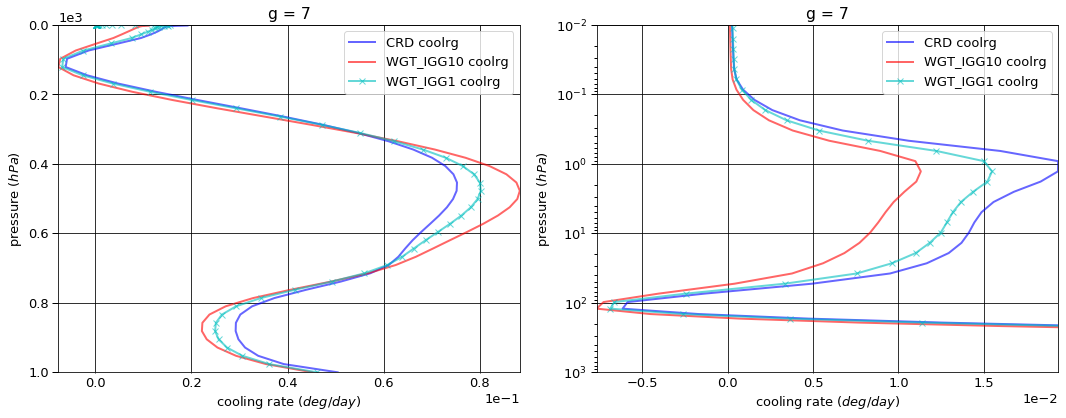

# Figure: cooling rate g-group 8

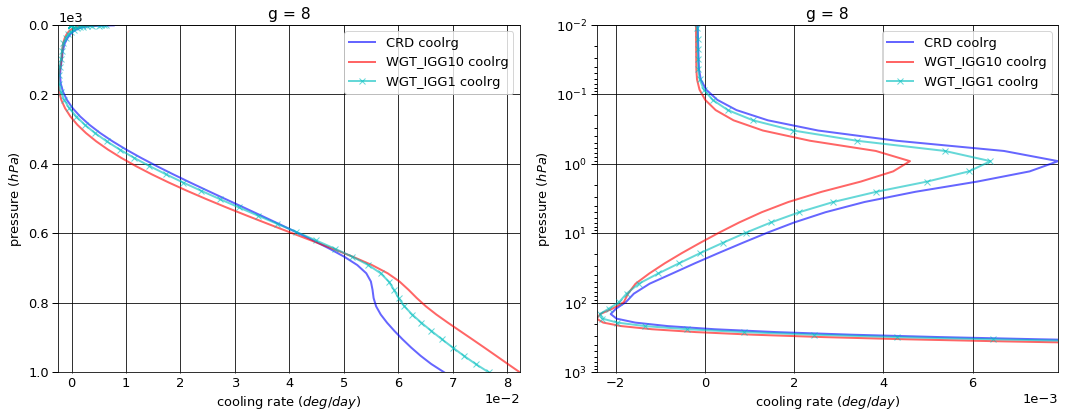

# Figure: cooling rate g-group 9

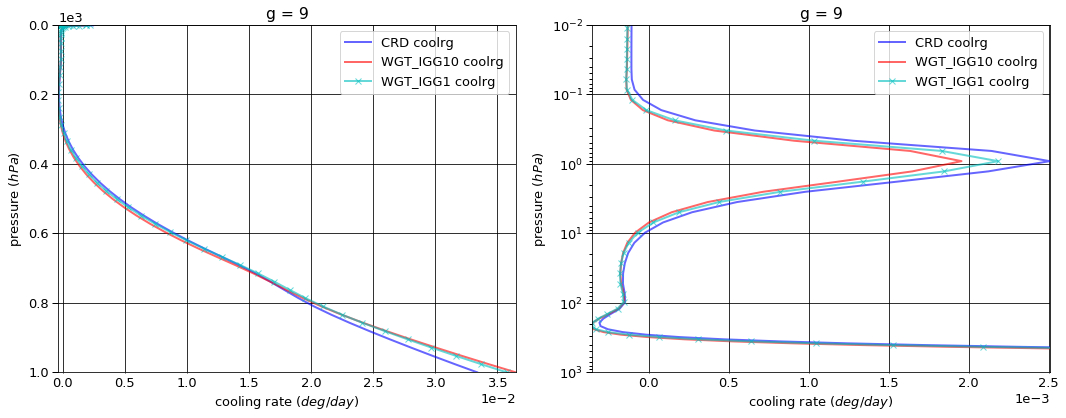

# Figure: cooling rate g-group total

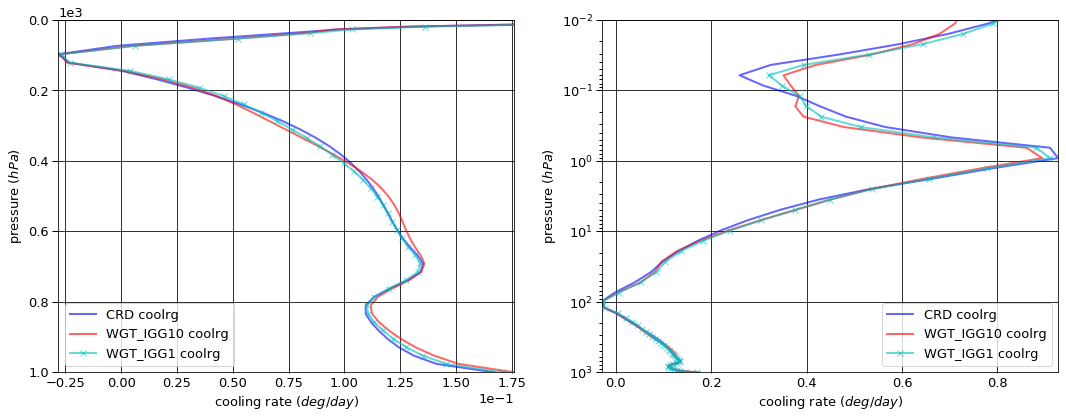

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.010493  0.000000  -0.010493
  1013.0   76     -0.028390  0.028204  -0.000186
2 0.0      1      -0.037364  0.000000  -0.037364
  1013.0   76     -0.063043  0.062547  -0.000496
3 0.0      1      -0.153894  0.000000  -0.153894
  1013.0   76     -0.275821  0.268417  -0.007404
4 0.0      1      -0.210575  0.000000  -0.210575
  1013.0   76     -0.476412  0.471960  -0.004452
5 0.0      1      -0.707239  0.000000  -0.707239
  1013.0   76     -1.822301  1.741960  -0.080341
6 0.0      1      -0.829060  0.000000  -0.829060
  1013.0   76     -2.493990  2.471769  -0.022221
7 0.0      1      -5.698222  0.000000  -5.698222
  1013.0   76    -10.342605  9.777056  -0.565549
8 0.0      1      -7.432292  0.000000  -7.432292
  1013.0   76     -8.780112  4.869797  -3.910315
9 0.0      1     -13.949027  0.000000 -13.949027
  1013.0   76    -14.209061  1.389230 -12.819831


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.010166  0.000000  -0.010166
  1013.0   76     -0.027627  0.027456  -0.000171
2 0.0      1      -0.038564  0.000000  -0.038564
  1013.0   76     -0.061443  0.061063  -0.000380
3 0.0      1      -0.157237  0.000000  -0.157237
  1013.0   76     -0.269868  0.268200  -0.001668
4 0.0      1      -0.217264  0.000000  -0.217264
  1013.0   76     -0.464064  0.461196  -0.002868
5 0.0      1      -0.567899  0.000000  -0.567899
  1013.0   76     -1.786697  1.775016  -0.011681
6 0.0      1      -0.796997  0.000000  -0.796997
  1013.0   76     -2.436054  2.416807  -0.019247
7 0.0      1      -5.615835  0.000000  -5.615835
  1013.0   76    -10.155711  9.746365  -0.409346
8 0.0      1      -7.517491  0.000000  -7.517491
  1013.0   76     -8.809063  5.061656  -3.747406
9 0.0      1     -14.221139  0.000000 -14.221139
  1013.0   76    -14.481208  1.411494 -13.069714


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.010237  0.000000  -0.010237
  1013.0   76     -0.027627  0.027456  -0.000171
2 0.0      1      -0.038070  0.000000  -0.038070
  1013.0   76     -0.061443  0.061063  -0.000380
3 0.0      1      -0.155731  0.000000  -0.155731
  1013.0   76     -0.269868  0.268199  -0.001669
4 0.0      1      -0.215547  0.000000  -0.215547
  1013.0   76     -0.464064  0.461196  -0.002868
5 0.0      1      -0.575723  0.000000  -0.575723
  1013.0   76     -1.786697  1.774262  -0.012435
6 0.0      1      -0.804423  0.000000  -0.804423
  1013.0   76     -2.436054  2.415900  -0.020154
7 0.0      1      -5.568002  0.000000  -5.568002
  1013.0   76    -10.155711  9.707275  -0.448436
8 0.0      1      -7.440681  0.000000  -7.440681
  1013.0   76     -8.809063  5.074244  -3.734819
9 0.0      1     -14.211925  0.000000 -14.211925
  1013.0   76    -14.481208  1.431020 -13.050188


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000327  0.000000  0.000327
  1013.0   76     0.000763 -0.000748  0.000015
2 0.0      1     -0.001200  0.000000 -0.001200
  1013.0   76     0.001600 -0.001484  0.000116
3 0.0      1     -0.003343  0.000000 -0.003343
  1013.0   76     0.005953 -0.000218  0.005736
4 0.0      1     -0.006689  0.000000 -0.006689
  1013.0   76     0.012347 -0.010764  0.001584
5 0.0      1      0.139340  0.000000  0.139340
  1013.0   76     0.035604  0.033056  0.068660
6 0.0      1      0.032063  0.000000  0.032063
  1013.0   76     0.057936 -0.054963  0.002974
7 0.0      1      0.082387  0.000000  0.082387
  1013.0   76     0.186894 -0.030691  0.156203
8 0.0      1     -0.085199  0.000000 -0.085199
  1013.0   76    -0.028951  0.191860  0.162909
9 0.0      1     -0.272112  0.000000 -0.272112
  1013.0   76    -0.272147  0.022264 -0.249883


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000256  0.000000  0.000256
  1013.0   76     0.000763 -0.000748  0.000015
2 0.0      1     -0.000706  0.000000 -0.000706
  1013.0   76     0.001600 -0.001484  0.000116
3 0.0      1     -0.001837  0.000000 -0.001837
  1013.0   76     0.005953 -0.000218  0.005735
4 0.0      1     -0.004972  0.000000 -0.004972
  1013.0   76     0.012347 -0.010764  0.001584
5 0.0      1      0.131516  0.000000  0.131516
  1013.0   76     0.035604  0.032302  0.067906
6 0.0      1      0.024637  0.000000  0.024637
  1013.0   76     0.057936 -0.055869  0.002067
7 0.0      1      0.130220  0.000000  0.130220
  1013.0   76     0.186894 -0.069781  0.117113
8 0.0      1     -0.008389  0.000000 -0.008389
  1013.0   76    -0.028951  0.204447  0.175496
9 0.0      1     -0.262898  0.000000 -0.262898
  1013.0   76    -0.272147  0.041790 -0.230357

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.887250
  1001.112500 75     0.000066
2 0.000312    1      0.016384
  1001.112500 75     0.000156
3 0.000312    1     -0.000993
  1001.112500 75     0.000855
4 0.000312    1      0.000128
  1001.112500 75     0.001196
5 0.000312    1      0.000830
  1001.112500 75     0.005891
6 0.000312    1      0.000074
  1001.112500 75     0.006661
7 0.000312    1      0.000102
  1001.112500 75     0.050417
8 0.000312    1     -0.000187
  1001.112500 75     0.068463
9 0.000312    1     -0.000102
  1001.112500 75     0.033411


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.616852
  1001.112500 75     0.000061
2 0.000312    1     -0.009383
  1001.112500 75     0.000137
3 0.000312    1      0.000074
  1001.112500 75     0.000600
4 0.000312    1      0.000179
  1001.112500 75     0.001031
5 0.000312    1      0.003353
  1001.112500 75     0.004092
6 0.000312    1      0.000066
  1001.112500 75     0.006146
7 0.000312    1      0.000040
  1001.112500 75     0.045167
8 0.000312    1     -0.000202
  1001.112500 75     0.082369
9 0.000312    1     -0.000118
  1001.112500 75     0.036516


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.806645
  1001.112500 75     0.000061
2 0.000312    1     -0.000986
  1001.112500 75     0.000137
3 0.000312    1     -0.000881
  1001.112500 75     0.000600
4 0.000312    1      0.000158
  1001.112500 75     0.001031
5 0.000312    1      0.003346
  1001.112500 75     0.004215
6 0.000312    1      0.000087
  1001.112500 75     0.006234
7 0.000312    1      0.000145
  1001.112500 75     0.046101
8 0.000312    1     -0.000185
  1001.112500 75     0.076654
9 0.000312    1     -0.000121
  1001.112500 75     0.035783


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.270398
  1001.112500 75    -0.000005
2 0.000312    1     -0.025767
  1001.112500 75    -0.000020
3 0.000312    1      0.001067
  1001.112500 75    -0.000255
4 0.000312    1      0.000051
  1001.112500 75    -0.000164
5 0.000312    1      0.002524
  1001.112500 75    -0.001799
6 0.000312    1     -0.000008
  1001.112500 75    -0.000514
7 0.000312    1     -0.000062
  1001.112500 75    -0.005251
8 0.000312    1     -0.000014
  1001.112500 75     0.013905
9 0.000312    1     -0.000016
  1001.112500 75     0.003105


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.080605
  1001.112500 75    -0.000005
2 0.000312    1     -0.017369
  1001.112500 75    -0.000020
3 0.000312    1      0.000113
  1001.112500 75    -0.000255
4 0.000312    1      0.000030
  1001.112500 75    -0.000164
5 0.000312    1      0.002516
  1001.112500 75    -0.001675
6 0.000312    1      0.000013
  1001.112500 75    -0.000426
7 0.000312    1      0.000043
  1001.112500 75    -0.004316
8 0.000312    1      0.000002
  1001.112500 75     0.008191
9 0.000312    1     -0.000019
  1001.112500 75     0.002372

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.028166,0.00000,-29.028166
1013.0,76,-38.491735,21.08094,-17.410794



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.142593,0.000000,-29.142593
1013.0,76,-38.491734,21.229253,-17.262481



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.020340,0.000000,-29.020340
1013.0,76,-38.491734,21.220616,-17.271119



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.144264e-01,0.000000,-0.114426
1013.0,76,6.740000e-07,0.148313,0.148312



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,7.826083e-03,0.000000,0.007826
1013.0,76,6.740000e-07,0.139675,0.139675


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.903485
1001.112500,75,0.167116



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.610862
1001.112500,75,0.176118



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.808209
1001.112500,75,0.170816



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.292623
1001.112500,75,0.009002



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.095277
1001.112500,75,0.003700


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000737,0.000718
2,0.001638,0.001596
3,0.007162,0.007011
4,0.012375,0.012056
5,0.047313,0.046418
6,0.064750,0.063288
7,0.268363,0.263841
8,0.227887,0.228856
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.344054e-19
2,2.155925e-20
3,1.982895e-21
4,1.784805e-21
5,1.648433e-22
6,7.248533e-22
7,6.798069e-23
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.344054e-19,NaN,0.000737,0.000718,0.000737,0.000718,1.0
2,2.155925e-20,0.091974,0.001638,0.001596,0.002375,0.002314,1.0
3,1.982895e-21,0.091974,0.007162,0.007011,0.009537,0.009325,1.0
4,1.784805e-21,0.900100,0.012375,0.012056,0.021913,0.021381,10.0
5,1.648433e-22,0.092359,0.047313,0.046418,0.069225,0.067799,10.0
6,7.248533e-22,4.397225,0.064750,0.063288,0.133975,0.131087,500.0
7,6.798069e-23,0.093785,0.268363,0.263841,0.402338,0.394928,500.0
8,6.375599e-24,0.093785,0.227887,0.228856,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
